In [1]:
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
categories = [
    'alt.atheism',
    'rec.sport.hockey',
    'talk.politics.guns',
    'sci.space',
]
# Charger le dataset
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data

# Prétraiter les documents
processed_docs = [simple_preprocess(doc) for doc in documents]


In [104]:
from gensim.models import Word2Vec

# Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(processed_docs, vector_size=100, window=5, min_count=2, sg=0, epochs=10)

# Trouver les mots similaires
similar_words = word2vec_model.wv.most_similar('space', topn=5)
print("Mots similaires à 'space':", similar_words)

# Trouver l'intrus
odd_one_out = word2vec_model.wv.doesnt_match(['puck', 'goal', 'hockey', 'planet'])
print("Intrus:", odd_one_out)


Mots similaires à 'space': [('nasa', 0.8156121969223022), ('program', 0.7771847248077393), ('shuttle', 0.7720154523849487), ('research', 0.7239426970481873), ('crypt', 0.7227862477302551)]
Intrus: planet


In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans

# Taguer les documents
tagged_docs = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(processed_docs)]

# Entraîner le modèle Doc2Vec
doc2vec_model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=2, epochs=20)

# Extraire les vecteurs de documents
doc_vectors = [doc2vec_model.dv[i] for i in range(len(tagged_docs))]

# Clustering avec KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(doc_vectors)

# Afficher les clusters
print("Clusters:", kmeans.labels_)


Clusters: [1 1 0 ... 1 1 1]


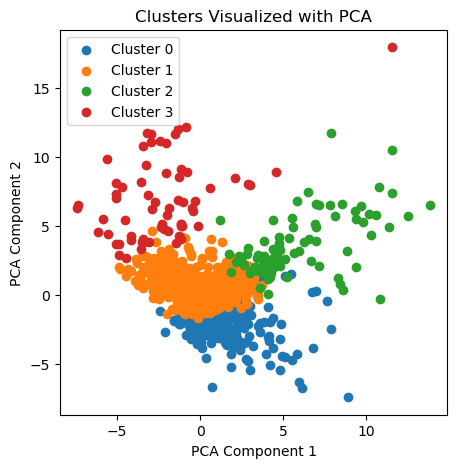

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduire les dimension avec PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(doc_vectors)

# Ploter les clusters
plt.figure(figsize=(5, 5))
for cluster_id in range(kmeans.n_clusters):
    cluster_points = reduced_vectors[kmeans.labels_ == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.title("Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [107]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Fonction pour récupérer les vecteurs des documents à partir de Word2Vec
def get_doc_vector_word2vec(doc, model):
    # Prendre la moyenne des vecteurs de mots pour representer le document
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # Si aucun mot n'est dans le vocab, retourner un vecteur de 0 
        return np.zeros(model.vector_size)

# Generer le vecteur de documents pour word2vec
word2vec_doc_vectors = [get_doc_vector_word2vec(doc, word2vec_model) for doc in processed_docs]

# Calculer les similarité cosinus
def compute_similarity_matrix(vectors):
    return cosine_similarity(vectors)

# Selection un sous ensemble de documents pour calculer la similarité
subset_indices = [0, 1]
word2vec_similarity_matrix = compute_similarity_matrix([word2vec_doc_vectors[i] for i in subset_indices])
doc2vec_similarity_matrix = compute_similarity_matrix([doc_vectors[i] for i in subset_indices])

# Display the actual target classes
print("Document Target Classes (for selected documents):")
for i in subset_indices:
    print(f"Document {i}: Target Class = {newsgroups.target[i]}")

# Display similarity matrices
print("\nWord2Vec Similarity Matrix:\n", word2vec_similarity_matrix)
print("\nDoc2Vec Similarity Matrix:\n", doc2vec_similarity_matrix)


Document Target Classes (for selected documents):
Document 0: Target Class = 2
Document 1: Target Class = 3

Word2Vec Similarity Matrix:
 [[1.        0.8450251]
 [0.8450251 1.       ]]

Doc2Vec Similarity Matrix:
 [[0.9999999  0.17482445]
 [0.17482445 1.        ]]
